# Train a FastText model with Slovene embeddings on the SLED categorization dataset

In [1]:
# Install and import fastText
!wget https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
!unzip v0.9.2.zip

%cd fastText-0.9.2

!pip install .
import fasttext as ft

--2022-08-31 05:34:35--  https://github.com/facebookresearch/fastText/archive/v0.9.2.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2 [following]
--2022-08-31 05:34:35--  https://codeload.github.com/facebookresearch/fastText/zip/refs/tags/v0.9.2
Resolving codeload.github.com (codeload.github.com)... 140.82.113.10
Connecting to codeload.github.com (codeload.github.com)|140.82.113.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘v0.9.2.zip’

v0.9.2.zip              [  <=>               ]   4.17M  15.5MB/s    in 0.3s    

2022-08-31 05:34:36 (15.5 MB/s) - ‘v0.9.2.zip’ saved [4369852]

Archive:  v0.9.2.zip
5b5943c118b0ec5fb9cd8d20587de2b2d3966dfe
   creating: fastText-0.9.2/
   creating: fastText-0.9.2/.circleci/
 

In [2]:
%cd /content
%pwd

/content


'/content'

In [3]:
# Install the parse module
!pip install parse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=eba0ba67537c2f888df485096d087eeef815b5332fe287a11475271cfbe221b1
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
Successfully built parse


In [4]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=2603a3a02545708a219d89de9754e1c3714312779fe50bf6b0c4a71fab4cdb4b
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [17]:
# Import necessary libraries
import parse
import fasttext as ft
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import time
import wget
import zipfile
import pandas as pd
from sklearn.metrics import classification_report

In [10]:
# Upload the data to google collab and define paths to them
# (click on the Folder on the right of the window, and click on the file icon ("Upload to session storage")
train = "/content/sled_categorization_TRAINSMALL_PREPROCESSED.txt"

test = "/content/sled_categorization_TEST_PREPROCESSED.txt"

dev = "/content/sled_categorization_DEV_PREPROCESSED.txt"

In [6]:
# Download and unzip a file with the Slovene embeddings
print('Downloading started')

#Defining the zip file URL
url = "https://www.clarin.si/repository/xmlui/bitstream/handle/11356/1204/embed.sl-token.ft.sg.vec.zip"

# Downloading the file by sending the request to the URL
embs = wget.download(url)
print('Downloading Completed')

# extracting the zip file contents
zipfile= zipfile.ZipFile(embs)
zipfile.extractall('data/')

In [11]:
# Parse the file to separate labels from text
def parse_file(path: str):
    """Reads fasttext formatted file and returns labels, texts."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            print("error parsing line ", line)
    return labels, texts

In [12]:
# Create a list of texts and labels from the train file
train_labels, train_texts = parse_file(train)

# Inspect the results
train_texts[:3]

['na tolminskem se je dopoldne zgodila prometna nesreča v kateri je umrl 43-letni voznik osebnega avtomobila po tem ko je zapeljal v 100 metrov globoko grapo  nesreča se je zgodila ob 916 uri po prvih ugotovitvah policistov je domačin peljal iz tolmina proti vasi zadlaz - žabče kjer je v neposredni bližini ene od tamkajšnjih stanovanjskih hiš zapeljal levo z vozišča globoko približno 100 metrov v grapo  poleg policistov iz tolmina in nove gorice ter novogoriške gorske policijske enote so na kraju nesreče posredovali tudi gasilci pripadniki gorske reševalne službe in reševalci iz tolmina v nadaljevanju je bila ugotovljena in potrjena identiteta voznika in sicer je za posledicami telesnih poškodb v prometni nesreči podlegel 43-letni voznik so sporočili iz policijske uprave nova gorica zdravnica je odredila sanitarno obdukcijo ki jo bodo opravili na inštitutu za sodno medicino v ljubljani o nesreči so obvestili tudi preiskovalno sodnico in državno tožilstvo v novi gorici',
 'na cesti zadl

In [13]:
# Create a list of labels - by creating a set, we get only unique labels from the list of all labels,
# then we transform the set back to a list

LABELS = list(set(train_labels))

LABELS

['__label__gospodarstvo',
 '__label__izobrazevanje',
 '__label__politika',
 '__label__zabava',
 '__label__okolje',
 '__label__vreme',
 '__label__prosticas',
 '__label__zdravje',
 '__label__kultura',
 '__label__crnakronika',
 '__label__sport',
 '__label__znanost',
 '__label__druzba']

In [14]:
def prediction_to_label(prediction):
    """Transforms predictions as returned by fasttext into pure labels."""
    return np.array(prediction[0])[:, 0]

# Create a function to evaluate the results (it calculates the scores and creates a confusion matrix)
def plot_cm():
    """
    Plots confusion matrix for prediction on the test set.
    Takes the predictions, named as y_pred, true values, named as y_true,
    and labels, named as LABELS.
    """
    # Plot the confusion matrix:
    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = LABELS
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)

    plt.tight_layout()
    fig1 = plt.gcf()
    plt.show()
    plt.draw()

    # Calculate micro and macro F1 scores
    microF1 = f1_score(y_true, y_pred, labels=LABELS, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=LABELS, average ="macro")

    print(f"Micro F1: {microF1:0.4}, Macro F1: {macroF1:0.4}")

    return microF1, macroF1

## Hyperparameter search

In [ ]:
# Create a list with results
results = []

Training started for epoch_num 300.
Training finished. Testing started.
Training took 13.11 minutes.


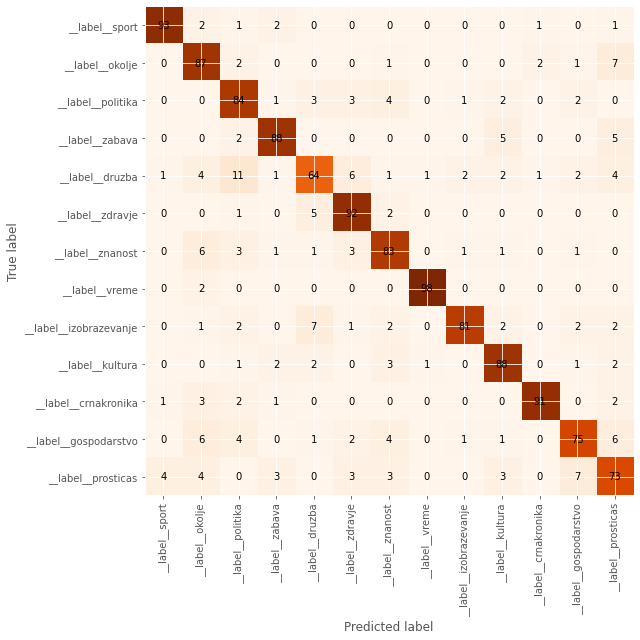

Micro F1: 0.8438, Macro F1: 0.8435
Testing took 0.04 minutes.




<Figure size 432x288 with 0 Axes>

In [ ]:
# Define which epochs we want to try
#exp_range = [10, 50, 100, 150]
# Additional experiments
#exp_range = [100, 200, 400, 600]
exp_range = [300]

for i in exp_range:
    print(f"Training started for epoch_num {i}.")

    training_start_time = time.time()

    model = ft.train_supervised(input=train,
                                epoch = i,
                                verbose = 2,
                                pretrainedVectors = "data/embed.sl-token.ft.sg.vec"
                                            )

    print(f"Training finished. Testing started.")
    print(f"Training took {round((time.time() - training_start_time)/60,2)} minutes.")

    testing_start_time = time.time()
    # Parse the dev files so that labels and texts are separated
    y_true, y_texts = parse_file(dev)

    # Evaluate the model on dev data
    y_pred = model.predict(y_texts)
    y_pred = prediction_to_label(y_pred)

    # Plot the confusion matrix:
    m, M = plot_cm()
    
    rezdict = dict(
        microF1=m,
        macroF1=M,
        epoch_num = i,
    )
    results.append(rezdict)

    print(f"Testing took {round((time.time() - testing_start_time)/60,2)} minutes.\n\n")

In [ ]:
results

[{'microF1': 0.8269230769230769,
  'macroF1': 0.827504253159148,
  'epoch_num': 100},
 {'microF1': 0.8361538461538461,
  'macroF1': 0.8359924186539833,
  'epoch_num': 200},
 {'microF1': 0.8461538461538461,
  'macroF1': 0.8457218138384108,
  'epoch_num': 400},
 {'microF1': 0.8469230769230769,
  'macroF1': 0.8463928042575369,
  'epoch_num': 600},
 {'microF1': 0.8438461538461539,
  'macroF1': 0.843512844635172,
  'epoch_num': 300}]

As we can see, the scores rise until the epoch 400, afterwards they remain around 0.85. For testing, I will use 400 epochs.

In [ ]:
# Reorder the list
ordered_results = results
myorder = [0, 1, 4, 2, 3]
ordered_results = [results[i] for i in myorder]
ordered_results

[{'microF1': 0.8269230769230769,
  'macroF1': 0.827504253159148,
  'epoch_num': 100},
 {'microF1': 0.8361538461538461,
  'macroF1': 0.8359924186539833,
  'epoch_num': 200},
 {'microF1': 0.8438461538461539,
  'macroF1': 0.843512844635172,
  'epoch_num': 300},
 {'microF1': 0.8461538461538461,
  'macroF1': 0.8457218138384108,
  'epoch_num': 400},
 {'microF1': 0.8469230769230769,
  'macroF1': 0.8463928042575369,
  'epoch_num': 600}]

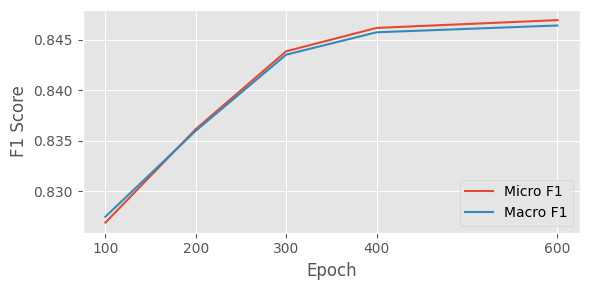

In [ ]:
# Analyse the results of experiments
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.style.use("ggplot")

# make data

x = []
mi = []
ma = []

for i in ordered_results:
    x.append(i['epoch_num'])
    mi.append(i['microF1'])
    ma.append(i["macroF1"])

# plot
plt.figure(figsize=(6,3), dpi=100)

plt.plot(x, mi, label="Micro F1")
plt.plot(x, ma, label="Macro F1")

plt.xticks(x)

plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc="lower right")

plt.tight_layout()

#plt.savefig(Epoch-number-hyperparameter-search.png")
plt.show()


In [ ]:
# Save results of the hyperparameter search as a JSON file
import json

with open("SLED-with-embeddings-hyperparameter-search-results.json","w") as file:
  json.dump(ordered_results, file)

## Training the model and testing it on the test set

Training started.
Training finished. Testing started.
Training took 15.73 minutes.


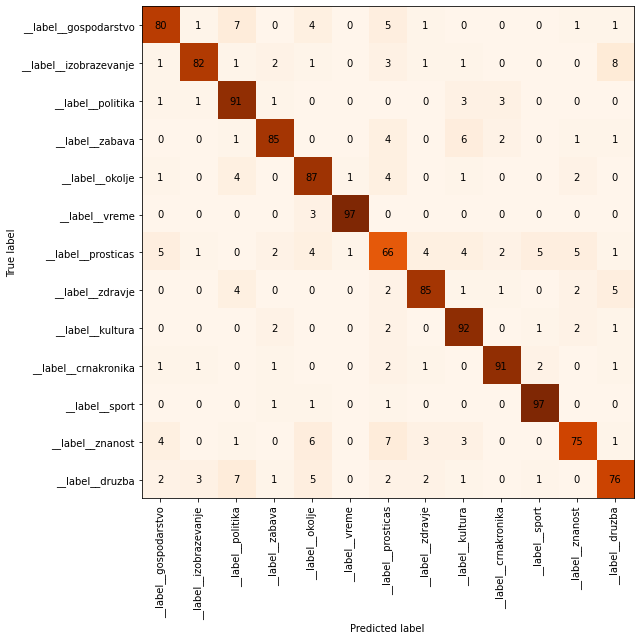

Micro F1: 0.8492, Macro F1: 0.8487
                        precision    recall  f1-score   support

 __label__gospodarstvo       0.84      0.80      0.82       100
__label__izobrazevanje       0.92      0.82      0.87       100
     __label__politika       0.78      0.91      0.84       100
       __label__zabava       0.89      0.85      0.87       100
       __label__okolje       0.78      0.87      0.82       100
        __label__vreme       0.98      0.97      0.97       100
    __label__prosticas       0.67      0.66      0.67       100
      __label__zdravje       0.88      0.85      0.86       100
      __label__kultura       0.82      0.92      0.87       100
  __label__crnakronika       0.92      0.91      0.91       100
        __label__sport       0.92      0.97      0.94       100
      __label__znanost       0.85      0.75      0.80       100
       __label__druzba       0.80      0.76      0.78       100

              accuracy                           0.85      1300
   

<Figure size 432x288 with 0 Axes>

In [18]:
test_results = []

for i in [400]:
    print(f"Training started.")

    training_start_time = time.time()

    model = ft.train_supervised(input=train,
                                epoch = 400,
                                verbose = 2,
                                pretrainedVectors = "data/embed.sl-token.ft.sg.vec")

    print(f"Training finished. Testing started.")
    print(f"Training took {round((time.time() - training_start_time)/60,2)} minutes.")

    testing_start_time = time.time()
    # Parse the test files so that labels and texts are separated
    y_true, y_texts = parse_file(test)

    # Test the model on test data
    y_pred = model.predict(y_texts)
    y_pred = prediction_to_label(y_pred)

    # Plot the confusion matrix:
    m, M = plot_cm()
    
    rezdict = dict(
        microF1=m,
        macroF1=M,
        epoch_num = i,
        y_true = {"y_true": y_true, "y_texts": y_texts},
        y_pred = y_pred,
    )
    test_results.append(rezdict)

        # Add classification report
    print(classification_report(y_true, y_pred, labels=LABELS))

    print(f"Testing took {round((time.time() - testing_start_time)/60,2)} minutes.\n\n")

In [19]:
# Inspect results in a dataframe format

df = pd.DataFrame(test_results)

df

,microF1,macroF1,epoch_num,y_true,y_pred
0,0.849231,0.84872,400,"{'y_true': ['__label__crnakronika', '__label__...","[__label__crnakronika, __label__crnakronika, _..."


In [20]:
# Save results as csv file
df.to_csv("SLED-results-on-test-with-embeddings.csv", sep = "\t")

In [22]:
# Save the model
model.save_model("FastText-model-trainsmall-embeddings.bin")

In [23]:
# Save it to Wandb
!pip install wandb
import wandb

# Login to wandb
wandb.login()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.5 MB/s 
     |████████████████████████████████| 157 kB 45.1 MB/s 
     |████████████████████████████████| 181 kB 46.9 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 54.7 MB/s 
     |████████████████████████████████| 157 kB 48.6 MB/s 
     |████████████████████████████████| 157 kB 45.8 MB/s 
     |████████████████████████████████| 157 kB 44.1 MB/s 
     |████████████████████████████████| 156 kB 35.3 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=a8e0e518998f0e3a6e5ae23042782ed38d2a66309e6482b6da512afd047210e6
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [24]:
# Save the trained model to Wandb
run = wandb.init(project="SLED-categorization", name="saving-trainsmall-embeddings-model")
trained_model_artifact = wandb.Artifact("SLED-categorization-trainsmall-embeddings-model", type="model", description="a fastText model trained on the 'trainsmall' SLED dataset, trained with the pre-trained embeddings.")
trained_model_artifact.add_dir("/content/model")
run.log_artifact(trained_model_artifact)

wandb: Currently logged in as: tajak. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (/content/model)... Done. 10.4s
